# Отчёт по лабораторной работе №2 "Логистическая регрессия"

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
def load_file(filename, names):
    return pd.read_csv(filename, header=None, names=names)

# 1. Загрузите данные ex2data1.txt из текстового файла.

In [3]:
df = load_file('ex2data1.txt', ['first_exam', 'second_exam', 'accepted'])
X_train, y_train = df.filter(['first_exam', 'second_exam']), df['accepted']
df

,first_exam,second_exam,accepted
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1
...,...,...,...
95,83.489163,48.380286,1
96,42.261701,87.103851,1
97,99.315009,68.775409,1
98,55.340018,64.931938,1


# 2. Постройте график, где по осям откладываются оценки по предметам, а точки обозначаются двумя разными маркерами в зависимости от того, поступил ли данный студент в университет или нет.

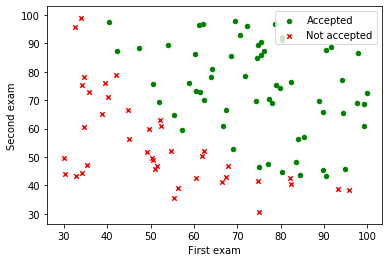

In [4]:
z_true = df[df['accepted'] == 1]
z_false = df[df['accepted'] == 0]
fig, ax = plt.subplots()
ax.scatter(z_true['first_exam'], z_true['second_exam'], marker='o', c='g', label='Accepted', s=20)
ax.scatter(z_false['first_exam'], z_false['second_exam'], marker='x', c='r', label='Not accepted', s=20)
ax.legend(loc='upper right');
ax.set_xlabel('First exam')
ax.set_ylabel('Second exam')
plt.show()

### Реализация логистической регрессии в объекто-ориентированном стиле

In [5]:
from utils import sigmoid

class LogisticRegression:
    THRESHOLD = 1e-6

    def __init__(self, fit_method='gradient_descent', max_steps=100000,
                 learning_rate=0.01, regularized=False, reg_L=0.5, log=False):
        self.weights = []
        self.max_steps = max_steps
        self.learning_rate = learning_rate
        self.regularized = regularized
        self.reg_L = reg_L
        self.cost_func = self.cost_func_regularized if regularized else self.cost_func_non_regularized
        self.cost_der = self.cost_der_regularized if regularized else self.cost_der_non_regularized
        self.fit_method = getattr(self, fit_method)
        self.log = log
        
    def fit(self, X, y):
        if hasattr(X, 'values'):
            X = X.values
        if hasattr(y, 'values'):
            y = y.values

        X = X.astype('float64') 
        y = y.astype('float64')
        
        if not self.regularized:
            X = np.column_stack((np.ones(X.shape[0]), X))
        
        self.fit_method(X, y)
    
    def predict(self, X):
        if self.weights is None:
            raise Exception("Model is not trained. Call `fit` method.")

        X = np.array(X)
        if not self.regularized:
            X = np.insert(X, 0, 1)
        h = self.calculate_hypotesis(X)
        return 1 if h >= 0.5 else 0
    
    def gradient_descent(self, X, y):
        self.cost_history = []
        self.weights = np.zeros(X.shape[1])
        cur_loss = self.cost_func(X, y)

        cur_step = 0
        while cur_step < self.max_steps:
            cur_step += 1
            self.gradient_descent_step(X, y)
            new_loss = self.cost_func(X, y)
            self.cost_history.append(new_loss)
            if abs(new_loss - cur_loss) < self.THRESHOLD:
                break

            cur_loss = new_loss
    
    def gradient_descent_step(self, X, y):
        gradient = self.cost_der(X, y, self.weights)
        gradient *= self.learning_rate
        self.weights -= gradient
    
    def cost_func_non_regularized(self, X, y, weights=None):
        if weights is None:
            weights = self.weights
        
        predictions = self.calculate_hypotesis(X, weights)
        cost_trues = y * np.log(predictions)
        cost_falses = (1 - y) * np.log(1 - predictions)
        total_cost = -np.mean(cost_trues + cost_falses)
        return total_cost
    
    def cost_func_regularized(self, X, y, weights=None):
        if weights is None:
            weights = self.weights
        
        cost = self.cost_func_non_regularized(X, y, weights)
        weights_R = weights[1:]
        total_cost = cost + (self.reg_L / 2 / X.shape[0]) * np.dot(weights_R.T, weights_R)
        return total_cost
    
    def calculate_hypotesis(self, X, weights=None):
        if weights is None:
            weights = self.weights

        return sigmoid(X.dot(weights))
    
    def cost_der_non_regularized(self, X, y, theta):
        predictions = self.calculate_hypotesis(X, weights=theta)
        sq_error = predictions - y
        gradient = np.dot(X.T, sq_error)
        gradient /= X.shape[0]
        return gradient

    def cost_der_regularized(self, X, y, theta):
        predictions = self.calculate_hypotesis(X, weights=theta)
        sq_error = predictions - y
        gradient_first = np.dot(X.T[:1], sq_error)
        gradient_full = np.dot(X.T[1:], sq_error) + self.reg_L * theta[1:]
        gradient = np.insert(gradient_full, 0, gradient_first)
        gradient /= X.shape[0]
        return gradient
    
    def nelder_mead_algo(self, X, y):
        from scipy.optimize import fmin

        N = X.shape[0]

        def func(theta):
            return self.cost_func(X, y, theta)
        
        init_theta = np.zeros(X.shape[1])
        self.weights = fmin(func, init_theta, xtol=self.THRESHOLD, maxfun=100000)
    
    def bfgs_algo(self, X, y):
        from scipy.optimize import fmin_bfgs

        N = X.shape[0]

        def func(theta):
            return self.cost_func(X, y, theta)
        
        def func_der(theta):
            return self.cost_der(X, y, theta)

        init_theta = np.zeros(X.shape[1])
        self.weights = fmin_bfgs(func, init_theta, fprime=func_der, gtol=self.THRESHOLD, disp=self.log)

# 3. Реализуйте функции потерь J(θ) и градиентного спуска для логистической регрессии с использованием векторизации.

Функция потерь реализована в классе `LogisticRegression` в методе `cost_func_non_regularized`.

Градиентный спуск реализован в классе `LogisticRegression` в методах `gradient_descent` и `gradient_descent_step`.

In [6]:
cls_grad = LogisticRegression(fit_method='gradient_descent', max_steps=300000, learning_rate=0.004)
cls_grad.fit(X_train, y_train)
print(f'Minimum cost function value: {cls_grad.cost_history[-1]}')
print(f'Iterations: {len(cls_grad.cost_history)}')
print(f'Weights: {cls_grad.weights}')

Minimum cost function value: 0.20379167132378806
Iterations: 264018
Weights: [-24.03770043   0.19769988   0.19281427]


# 4. Реализуйте другие методы (как минимум 2) оптимизации для реализованной функции стоимости.
Выбранные методы:  
    - Нелдера — Мида
    - Бройдена — Флетчера — Гольдфарба — Шанно

In [7]:
cls_nm = LogisticRegression(fit_method='nelder_mead_algo')
cls_nm.fit(X_train, y_train)
print(f'Weights: {cls_nm.weights}')

Optimization terminated successfully.
         Current function value: 0.203498
         Iterations: 185
         Function evaluations: 339
Weights: [-25.16133398   0.20623172   0.2014716 ]


In [8]:
cls_bfgs = LogisticRegression(fit_method='bfgs_algo', log=True)
cls_bfgs.fit(X_train, y_train)
print(f'Weights: {cls_bfgs.weights}')

Optimization terminated successfully.
         Current function value: 0.203498
         Iterations: 23
         Function evaluations: 31
         Gradient evaluations: 31
Weights: [-25.16133284   0.2062317    0.2014716 ]


Как можно видеть из вывода, все методы минимазации функции стоимости дают приблизительно одинаковые результаты.

# 5. Реализуйте функцию предсказания вероятности поступления студента в зависимости от значений оценок по экзаменам.

Функция предсказания реализована в классе `LogisticRegression` в методе `predict`.

# 6. Постройте разделяющую прямую, полученную в результате обучения модели. Совместите прямую с графиком из пункта 2.

Из графика можно видеть, что граница решений разделяет два класс достаточно точно с минимальными ошибками. 

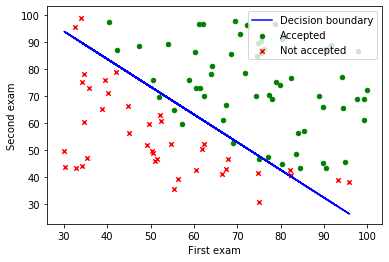

In [9]:
z_true = df[df['accepted'] == 1]
z_false = df[df['accepted'] == 0]

def decision_boundary(x, weights):
    return -(weights[0] + weights[1] * x) / weights[2]

fig, ax = plt.subplots()
ax.scatter(z_true['first_exam'], z_true['second_exam'], marker='o', c='g', label='Accepted', s=20)
ax.scatter(z_false['first_exam'], z_false['second_exam'], marker='x', c='r', label='Not accepted', s=20)
ax.plot(z_false['first_exam'],
        [decision_boundary(i, cls_grad.weights) for i in z_false['first_exam']],
        c='b', label='Decision boundary')
ax.legend(loc='upper right');
ax.set_xlabel('First exam')
ax.set_ylabel('Second exam')
plt.show()

# 7. Загрузите данные ex2data2.txt из текстового файла.

In [10]:
df = load_file('ex2data2.txt', names=['first_test', 'second_test', 'passed'])
X_train, y_train = df.filter(['first_test', 'second_test']), df['passed']
df

,first_test,second_test,passed
0,0.051267,0.699560,1
1,-0.092742,0.684940,1
2,-0.213710,0.692250,1
3,-0.375000,0.502190,1
4,-0.513250,0.465640,1
...,...,...,...
113,-0.720620,0.538740,0
114,-0.593890,0.494880,0
115,-0.484450,0.999270,0
116,-0.006336,0.999270,0


# 8. Постройте график, где по осям откладываются результаты тестов, а точки обозначаются двумя разными маркерами в зависимости от того, прошло ли изделие контроль или нет.

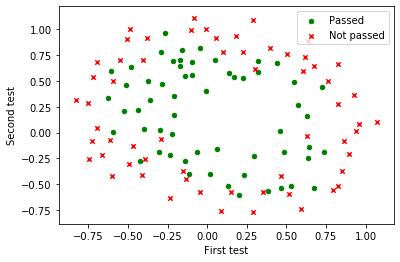

In [11]:
z_true = df[df['passed'] == 1]
z_false = df[df['passed'] == 0]
fig, ax_reg = plt.subplots()
ax_reg.scatter(z_true['first_test'], z_true['second_test'], marker='o', c='g', label='Passed', s=20)
ax_reg.scatter(z_false['first_test'], z_false['second_test'], marker='x', c='r', label='Not passed', s=20)
ax_reg.legend(loc='upper right');
ax_reg.set_xlabel('First test')
ax_reg.set_ylabel('Second test')
plt.show()

# 9. Постройте все возможные комбинации признаков x1 (результат первого теста) и x2 (результат второго теста), в которых степень полинома не превышает 6 (всего 28 комбинаций).

In [12]:
def build_poly_features(x1, x2, log=False):
    degree = 6
    res = []
    str_res = []

    for i in range(degree + 1):
        for j in range(i, degree + 1):
            res.append(x1**(j - i) * x2**i)
            first = '' if j - i == 0 else 'x1' if j - i == 1 else f'x1^{j - i}'
            second = '' if i == 0 else 'x2' if i == 1 else f'x2^{i}'
            if not first and not second:
                str_append = '1'
            elif first and not second:
                str_append = first
            elif second and not first:
                str_append = second
            else:
                str_append = f"{first}*{second}"
            str_res.append(str_append)

    str_res = ' + '.join(str_res)
    if log:
        print(str_res)
    assert len(res) == 28
    return np.array(res).T

In [13]:
X_poly = build_poly_features(X_train['first_test'], X_train['second_test'], log=True)

1 + x1 + x1^2 + x1^3 + x1^4 + x1^5 + x1^6 + x2 + x1*x2 + x1^2*x2 + x1^3*x2 + x1^4*x2 + x1^5*x2 + x2^2 + x1*x2^2 + x1^2*x2^2 + x1^3*x2^2 + x1^4*x2^2 + x2^3 + x1*x2^3 + x1^2*x2^3 + x1^3*x2^3 + x2^4 + x1*x2^4 + x1^2*x2^4 + x2^5 + x1*x2^5 + x2^6


# 10. Реализуйте L2-регуляризацию для логистической регрессии и обучите ее на расширенном наборе признаков методом градиентного спуска

In [14]:
cls_grad_reg = LogisticRegression(fit_method='gradient_descent', regularized=True,
                                  max_steps=300000, learning_rate=0.5, reg_L=0.5)
cls_grad_reg.fit(X_poly, y_train)
print(f'Minimum cost function value: {cls_grad_reg.cost_history[-1]}')
print(f'Iterations: {len(cls_grad_reg.cost_history)}')
print(f'Weights: {cls_grad_reg.weights}')

Minimum cost function value: 0.4830842899534604
Iterations: 810
Weights: [ 1.65208622  0.94431514 -2.64940137  0.25975329 -1.94720963 -0.28830575
 -1.40795909  1.63711103 -1.41181861 -0.55414548 -0.06395618 -0.30130378
  0.05023522 -1.9845273  -0.51557881 -0.86765101 -0.03547762 -0.40798724
 -0.18554811 -0.44731424 -0.41074822  0.02884999 -1.60347872 -0.46001569
 -0.46740685 -0.52305424 -0.25283157 -1.18129922]


# 11. Реализуйте другие методы оптимизации.

Используем ранее выбранные алгоритмы оптимизации

In [15]:
cls_nm_reg = LogisticRegression(fit_method='nelder_mead_algo', regularized=True)
cls_nm_reg.fit(X_poly, y_train)
print(f'Weights: {cls_nm_reg.weights}')

Optimization terminated successfully.
         Current function value: 0.555505
         Iterations: 25954
         Function evaluations: 31091
Weights: [ 1.12594906  0.24134085 -2.31420683  0.55470573 -1.67237848 -0.40342394
  0.16484985  0.80201203 -0.92787628  0.29253867  1.11388032  0.30459765
  0.77128112 -1.50790055 -0.06941374  0.18185012  1.78287659  0.10760548
  1.23201507 -1.16820284 -1.22854238  0.56241007 -0.94218806  0.97961079
 -0.19487654 -0.73439587  1.2956786  -1.05680772]


In [17]:
cls_bfgs_reg = LogisticRegression(fit_method='bfgs_algo', regularized=True, log=True)
cls_bfgs_reg.fit(X_poly, y_train)
print(f'Weights: {cls_bfgs_reg.weights}')

Optimization terminated successfully.
         Current function value: 0.482934
         Iterations: 70
         Function evaluations: 71
         Gradient evaluations: 71
Weights: [ 1.69992017e+00  9.73425710e-01 -2.71205027e+00  2.69841288e-01
 -1.97406880e+00 -3.01656781e-01 -1.42846670e+00  1.67267436e+00
 -1.49381280e+00 -5.67645033e-01 -2.05207890e-02 -2.95925875e-01
  8.26085884e-02 -2.11922466e+00 -5.01522975e-01 -8.94137108e-01
  1.63371223e-03 -4.13878871e-01 -1.94825890e-01 -4.75526451e-01
 -4.35533804e-01  5.34666739e-02 -1.62994970e+00 -4.80852527e-01
 -4.86440776e-01 -4.74910329e-01 -2.77072656e-01 -1.13402788e+00]


Как видим, результаты получились схожими для всех алгоритмов

# 12. Реализуйте функцию предсказания вероятности прохождения контроля изделием в зависимости от результатов тестов.

Функция предсказания реализована в классе LogisticRegression в методе predict.

In [19]:
print(f"Predicted class: {cls_grad_reg.predict(X_poly[0])}, actual class: {y_train[0]}")
print(f"Predicted class: {cls_nm_reg.predict(X_poly[0])}, actual class: {y_train[0]}")
print(f"Predicted class: {cls_bfgs_reg.predict(X_poly[0])}, actual class: {y_train[0]}")

Predicted class: 1, actual class: 1
Predicted class: 1, actual class: 1
Predicted class: 1, actual class: 1


# 13. Постройте разделяющую кривую, полученную в результате обучения модели. Совместите прямую с графиком из пункта 8.

In [20]:
def decision_boundary_contour(theta1, theta2, theta3):
    u = np.linspace(-1, 1.2, 50)
    v = np.linspace(-1, 1.3, 50)
    z1 = np.zeros(shape=(len(u), len(v)))
    z2 = np.zeros(shape=(len(u), len(v)))
    z3 = np.zeros(shape=(len(u), len(v)))
    for i in range(len(u)):
        for j in range(len(v)):
            z1[i, j] = build_poly_features(np.array(u[i]), np.array(v[j])).dot(theta1)
            z2[i, j] = build_poly_features(np.array(u[i]), np.array(v[j])).dot(theta2)
            z3[i, j] = build_poly_features(np.array(u[i]), np.array(v[j])).dot(theta3)

    z1 = z1.T
    z2 = z2.T
    z3 = z3.T
    fig, ax_reg = plt.subplots()
    ax_reg.contour(u, v, z1, levels=0, colors='b')
    ax_reg.contour(u, v, z2, levels=0, colors='g')
    ax_reg.contour(u, v, z3, levels=0, colors='y')
    z_true = df[df['passed'] == 1]
    z_false = df[df['passed'] == 0]
    ax_reg.scatter(z_true['first_test'], z_true['second_test'], marker='o', c='g', label='Passed', s=20)
    ax_reg.scatter(z_false['first_test'], z_false['second_test'], marker='x', c='r', label='Not passed', s=20)
    ax_reg.legend(loc='upper right');
    ax_reg.set_xlabel('First test')
    ax_reg.set_ylabel('Second test')
    ax_reg.set_title('Decision boundary, lambda = %f' % cls_grad_reg.reg_L)
    plt.show()

Проведём границу решений для всех трёх алгоритмов. Можно увидеть, что алгоритмы дают результаты, на основе которых можно построить приблизительно одинаковые границы с некоторой погрешностью.

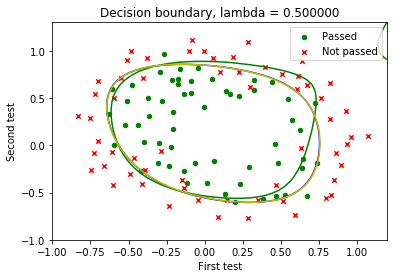

In [21]:
decision_boundary_contour(cls_grad_reg.weights, cls_nm_reg.weights, cls_bfgs_reg.weights)

# 14. Попробуйте различные значения параметра регуляризации λ. Как выбор данного значения влияет на вид разделяющей кривой? Ответ дайте в виде графиков.

In [24]:
cls1 = LogisticRegression(fit_method='gradient_descent', max_steps=300000, learning_rate=0.5,
                          regularized=True, reg_L=0.5)
cls1.fit(X_poly, y_train)

cls2 = LogisticRegression(fit_method='gradient_descent', max_steps=300000, learning_rate=0.5,
                          regularized=True, reg_L=0.05)
cls2.fit(X_poly, y_train)

cls3 = LogisticRegression(fit_method='gradient_descent', max_steps=300000, learning_rate=0.5,
                          regularized=True, reg_L=0.005)
cls3.fit(X_poly, y_train)

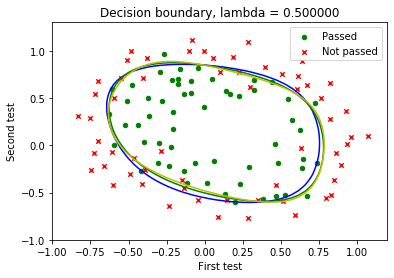

In [25]:
decision_boundary_contour(cls1.weights, cls2.weights, cls3.weights)

Как видим из графика, изменение параметра регуляризации λ не производит сильного влияния на границу решений.

# 15. Загрузите данные ex2data3.mat из файла.

In [26]:
from scipy.io import loadmat

mat = loadmat('ex2data3.mat')
X_train, y_train = mat['X'], mat['y']
y_train = y_train.reshape(y_train.shape[0])
y_train = np.where(y_train != 10, y_train, 0)

# 16. Визуализируйте несколько случайных изображений из набора данных. Визуализация должна содержать каждую цифру как минимум один раз.

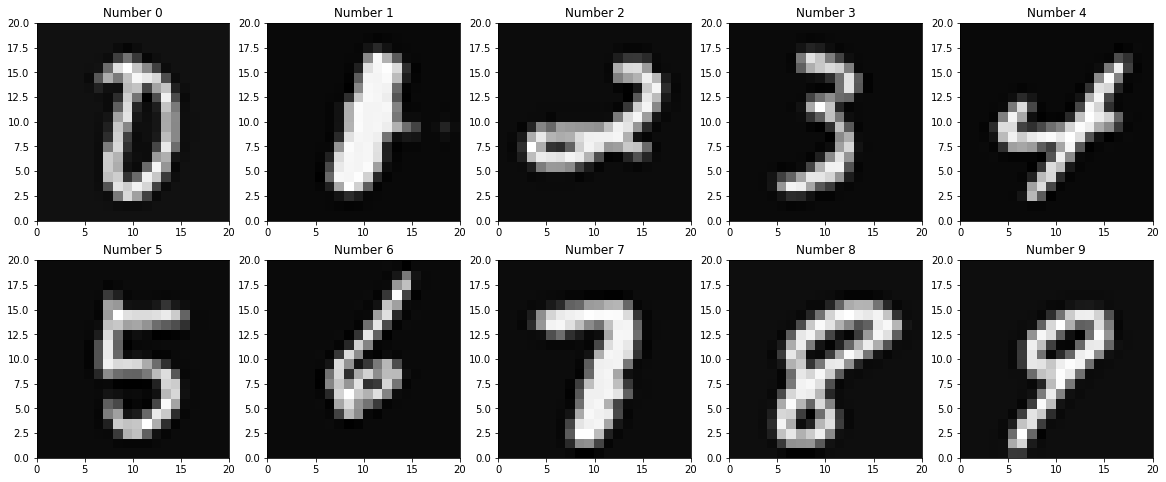

In [27]:
def vector_to_matrix(x):
    len_vec = len(x)
    step = int(np.sqrt(len_vec))
    assert step ** 2 == len_vec, 'Matrix should be squared' 
    matrix = [x[left:left+step] for left in range(0, len_vec, step)]
    np_matrix = np.array(matrix).T
    reversed_matrix = np.flip(np_matrix, axis=0)
    return reversed_matrix

nums = list(range(150, 5000, 500))
pictures = [vector_to_matrix(X_train[i]) for i in nums]

fig, axs = plt.subplots(2, 5, figsize=(20, 8))
for i, ax in enumerate(axs.flatten()):
    ax.pcolor(pictures[i], cmap=cm.gray)
    res = y_train[nums[i]]
    if res == 10:
        res = 0
    ax.set_title(f'Number {res}')

plt.show()

# 17. Реализуйте бинарный классификатор с помощью логистической регрессии с использованием векторизации (функции потерь и градиентного спуска).


Бинарный классификатор c использованием векторизации реализован в классе `LogisticRegression`. Он содержит функцию потерь `cost_func_non_regularized`, которая используется в методе градиентного спуска `gradient_descent`.

# 18. Добавьте L2-регуляризацию к модели.

Регуляризация добавляется к модели путём передачи в конструктор параметера `regularized=True`. В этом случае будет использовать использоваться функция стоимости `cost_func_regularized`. Градиент также будет высчитываться с учётом параметера регуляризации.

# 19. Реализуйте многоклассовую классификацию по методу “один против всех”.

Многоклассовая классификация реализована в классе `MulticlassLogisticRegression`. Обучается 10 бинарных классификаторов, по одному для каждого класса.

In [28]:
class MulticlassLogisticRegression:
    classifier = LogisticRegression

    def __init__(self, num_classes=10):
        self.num_classes = num_classes
        self.classifiers = [
            self.classifier(fit_method='gradient_descent', learning_rate=0.5, regularized=True, reg_L=0.1)
            for i in range(num_classes)
        ]
    
    def fit(self, X, y):
        for i in range(self.num_classes):
            y_train = (y == i).astype(int)
            self.classifiers[i].fit(X, y_train)
    
    def predict(self, X):
        h = []
        for cls in self.classifiers:
            h.append(cls.calculate_hypotesis(X))
            
        return np.argmax(np.array(h), axis=0)

# 20. Реализуйте функцию предсказания класса по изображению с использованием обученных классификаторов.

Функция предсказания реализована в классе `MulticlassLogisticRegression` в методе `predict`. Каждый из обученных классификаторов высчитывает гипотезу - вероятность того, что картинка принадлежит соответствующему классу.

In [29]:
cls_mult = MulticlassLogisticRegression()
cls_mult.fit(X_train, y_train)

In [30]:
pred_value = cls_mult.predict(X_train[-1])
print(f"Predicted class: {pred_value}, actual class: {y_train[-1]}")

Predicted class: 9, actual class: 9


# 21. Процент правильных классификаций на обучающей выборке должен составлять около 95%.

In [31]:
def accuracy(cls, X, y):
    error = cls.predict(X) - y
    return 1.0 - (float(np.count_nonzero(error)) / len(error))

In [32]:
acc = accuracy(cls_mult, X_train, y_train)
print(f"Accuracy: {acc}")

Accuracy: 0.9588
